# XGBoost Classification
Train an XGBoost classifier on the F1 dataset with one-hot encoded categorical features and imputed/scaled numeric features. Uses train/val/test splits from `data/`.

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    balanced_accuracy_score,
    confusion_matrix,
)
import seaborn as sns
import xgboost as xgb

print("xgboost version:", xgb.__version__)

xgboost version: 3.1.2


In [16]:
CAT_COLS = [
    "driver_id",
    "constructor_id",
    "circuit_id",
]
NUM_COLS = [
    "grid_position",
    "quali_delta",
    "quali_tm_delta",
    "season_pts_driver",
    "season_pts_team",
    "last_3_avg",
    "is_street_circuit",
    "is_wet",
]
TARGET = "points_scored"
FEATURES = CAT_COLS + NUM_COLS

train_df = pd.read_csv("../../data/points_scored/grandprix_features_train.csv")
val_df   = pd.read_csv("../../data/points_scored/grandprix_features_val.csv")
test_df  = pd.read_csv("../../data/points_scored/grandprix_features_test.csv")

X_train, y_train = train_df[FEATURES], train_df[TARGET]
X_val,   y_val   = val_df[FEATURES],   val_df[TARGET]
X_test,  y_test  = test_df[FEATURES],  test_df[TARGET]
print(f"Splits -> train: {len(train_df)}, val: {len(val_df)}, test: {len(test_df)}")

Splits -> train: 3740, val: 479, test: 479


In [17]:
preprocess = ColumnTransformer(
    [
        ("cat", OneHotEncoder(handle_unknown="ignore"), CAT_COLS),
        (
            "num",
            Pipeline(
                [
                    ("imputer", SimpleImputer(strategy="median")),
                    ("scaler", StandardScaler()),
                ]
            ),
            NUM_COLS,
        ),
    ],
    remainder="drop",
)

X_train_enc = preprocess.fit_transform(X_train)
X_val_enc = preprocess.transform(X_val)
X_test_enc = preprocess.transform(X_test)

y_train = y_train.values
y_val = y_val.values
y_test = y_test.values

In [18]:
params = {
    "objective": "binary:logistic",
    "eval_metric": "logloss",
    "learning_rate": 0.05,
    "max_depth": 20,
    "min_child_weight": 1.0,
    "subsample": 0.9,
    "colsample_bytree": 0.9,
    "n_estimators": 2000,
    "random_state": 42,
    "n_jobs": -1,
    "scale_pos_weight": None,
}

pos = (y_train == 1).sum()
neg = (y_train == 0).sum()
params["scale_pos_weight"] = neg / pos if pos > 0 else 1.0
print("scale_pos_weight:", params["scale_pos_weight"])

dtrain = xgb.DMatrix(X_train_enc, label=y_train)
dval = xgb.DMatrix(X_val_enc, label=y_val)
dtest = xgb.DMatrix(X_test_enc, label=y_test)

evals = [(dtrain, "train"), (dval, "val")]
evals_result = {}
booster = xgb.train(
    params,
    dtrain,
    num_boost_round=params["n_estimators"],
    evals=evals,
    evals_result=evals_result,
    verbose_eval=False,
    early_stopping_rounds=50,
)
print("Best iteration:", booster.best_iteration + 1)

scale_pos_weight: 1.0216216216216216


/var/git/dl-project/venv/lib/python3.13/site-packages/xgboost/callback.py:386: UserWarning: [15:03:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "n_estimators" } are not used.

  self.starting_round = model.num_boosted_rounds()


Best iteration: 70


In [19]:
val_probs = booster.predict(dval)
thresholds = np.linspace(0.05, 0.95, 19)
best_thr, best_f1 = 0.5, -np.inf
for t in thresholds:
    preds = (val_probs >= t).astype(int)
    f1 = f1_score(y_val, preds, zero_division=0)
    if f1 > best_f1:
        best_f1, best_thr = f1, t
print(f"Best val F1: {best_f1:.3f} at threshold {best_thr:.2f}")

Best val F1: 0.819 at threshold 0.45


In [20]:
def evaluate_split(probs, y_true, threshold, name: str):
    preds = (probs >= threshold).astype(int)
    print(
        f"[{name}] thr={threshold:.2f} | "
        f"Precision: {precision_score(y_true, preds):.3f} | "
        f"Recall: {recall_score(y_true, preds):.3f} | "
        f"F1: {f1_score(y_true, preds):.3f} | "
        f"Balanced Acc: {balanced_accuracy_score(y_true, preds):.3f}"
    )
    cm = confusion_matrix(y_true, preds)
    print(cm)
    return preds

_ = evaluate_split(val_probs, y_val, best_thr, "Val")
test_probs = booster.predict(dtest)
test_preds = evaluate_split(test_probs, y_test, best_thr, "Test")

[Val] thr=0.45 | Precision: 0.791 | Recall: 0.850 | F1: 0.819 | Balanced Acc: 0.812
[[185  54]
 [ 36 204]]
[Test] thr=0.45 | Precision: 0.685 | Recall: 0.817 | F1: 0.745 | Balanced Acc: 0.720
[[149  90]
 [ 44 196]]


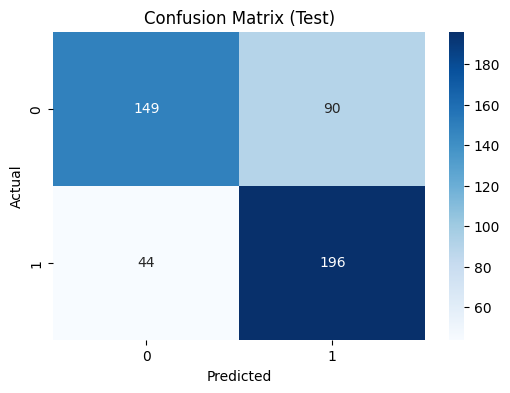

In [21]:
cm = confusion_matrix(y_test, test_preds)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix (Test)")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()
